In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
%matplotlib inline

2024-03-31 20:04:22.015592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 20:04:22.015756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 20:04:22.327646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
X_train = X_train/255 #normalizing pixel values to be between 0 and 1 rather than 0-255
X_test = X_test/255

In [4]:
y_train = to_categorical(y_train, 10) #onehot encode labels
y_test = to_categorical(y_test, 10)

In [5]:
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=7777) #create val set for hyperparam tuning


In [6]:
y_train.shape

(40000, 10)

In [7]:
X_train.shape

(40000, 32, 32, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import math
import matplotlib.pyplot as plt

class Network:
    def __init__(self, input_shape=(32, 32, 3), num_classes=10):
        initial_lr = 0.0002296904647915647  
        l2_reg_value = 0.0005829766440855362  

       
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=100000,  
            decay_rate=0.96,  
            staircase=True  
        )
        weight_initializer = glorot_uniform()
        dropout_rate = 0.25  
        
        self.model = Sequential([
            Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                   kernel_initializer=weight_initializer, kernel_regularizer=l2(l2_reg_value)),
            Conv2D(128, (3, 3), activation='relu', kernel_initializer=weight_initializer,
                   kernel_regularizer=l2(l2_reg_value)),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(dropout_rate),
            Flatten(),
            Dense(128, activation="relu", kernel_initializer=weight_initializer,
                  kernel_regularizer=l2(l2_reg_value)),
            Dropout(dropout_rate),
            Dense(num_classes, activation="softmax", kernel_initializer=weight_initializer)
        ])


        optimizer = Adam(learning_rate=lr_schedule)

        self.model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
        self.acc_history = []

        self.callbacks = []
    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=1):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                 batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True,
                                 callbacks=self.callbacks)
        return history

    def test(self, X_test, y_test):
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        self.acc_history.append(acc)
        return acc, loss

    def return_acc_history(self):
        return self.acc_history
    
    
    def get_layer_weight(self, i):
        return self.model.layers[i].get_weights()
    
    def set_layer_weight(self, i, weight):
        self.model.layers[i].set_weights(weight)
        
    def load_layer_weights(self, weights):
        self.model.set_weights(weights)
    
    def give_weights(self):
        return self.model.get_weights()

    def weight_len(self):
        return len(self.model.layers)

    def architecture(self):
        self.model.summary()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations=50):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = []
        self.children_population_weights = []
        self.acc = []
        self.norm_acc = []

    def create_population(self):
        self.population = [Network() for _ in range(self.population_size)]

    def train_generation(self, X_train, Y_train, X_val, Y_val):
        for member in self.population:
            member.train(X_train, Y_train, X_val, Y_val)



    def normalize(self):
        total_acc = sum(self.acc)
        self.norm_acc = [acc / total_acc for acc in self.acc] if total_acc != 0 else [1 / len(self.acc) for _ in self.acc]

    def clear_losses(self):
        self.acc = []
        self.norm_acc = []

    def mutate(self):
        for member in self.population:
            for i in range(member.weight_len()):
                if np.random.random() < self.mutation_rate:
                    old_weight = member.get_layer_weight(i)
     
                    mutation_magnitude = 0.05 if 'dense' in member.model.layers[i].name else 0.1
                    mutation_noise = [np.random.normal(loc=0.0, scale=mutation_magnitude, size=w.shape) for w in old_weight]
                    new_weight = [w + noise for w, noise in zip(old_weight, mutation_noise)]
                    member.set_layer_weight(i, new_weight)


    def reproduction(self):
        self.children_population_weights = []
        population_idx = list(range(len(self.population)))
        for _ in range(len(self.population)):
            parents = np.random.choice(population_idx, size=2, replace=False, p=self.norm_acc)
            parent1_weights = self.population[parents[0]].give_weights()
            parent2_weights = self.population[parents[1]].give_weights()

            mid_point = np.random.randint(0, len(parent1_weights))
            child_weights = parent1_weights[:mid_point] + parent2_weights[mid_point:]
            self.children_population_weights.append(child_weights)

        for i, member in enumerate(self.population):
            member.load_layer_weights(self.children_population_weights[i % len(self.children_population_weights)])

    def predict(self, X_test, Y_test):
        self.acc = []
        self.losses = []  
        for member in self.population:
            acc, loss = member.test(X_test, Y_test)
            self.acc.append(acc)
            self.losses.append(loss)

    def run_evolution(self, X_train, Y_train, X_val, Y_val, X_test, Y_test):
        best_weights = None
        best_accuracy = -1

        for episode in range(self.generations):
            print(f"Generation {episode + 1}/{self.generations}")
            self.clear_losses()

            self.train_generation(X_train, Y_train, X_val, Y_val)

            self.predict(X_val, Y_val)  


            gen_best_index = np.argmax(self.acc)
            gen_best_acc = self.acc[gen_best_index]

            if gen_best_acc > best_accuracy:
                best_accuracy = gen_best_acc
                best_weights = self.population[gen_best_index].give_weights()

            if episode != self.generations - 1:
                self.normalize()
                self.reproduction()
                self.mutate()


        if best_weights is not None:
            best_model = Network()
            best_model.load_layer_weights(best_weights)
            test_accuracy, test_loss = best_model.test(X_test, Y_test)
            print(f"Best Model - Test accuracy: {test_accuracy}, Test loss: {test_loss}")
        else:
            print("No best model found.")



    def clear_losses(self):
        self.acc = []
        self.losses = []  
        self.norm_acc = []



    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        for i, member in enumerate(self.population):
            acc_history = member.return_acc_history()
            if acc_history:  
                plt.plot(acc_history, label=f'Member {i+1}')
            else:
                print(f"No data to plot for Member {i+1}")
        plt.title('Genetic Algorithm: Accuracy Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

Generation 1/4
  19/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1055 - loss: 2.5330 

W0000 00:00:1711916158.523548      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3365 - loss: 1.9270

W0000 00:00:1711916167.679570      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3369 - loss: 1.9260 - val_accuracy: 0.5463 - val_loss: 1.4117
  20/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1049 - loss: 2.5097 

W0000 00:00:1711916175.912476      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1244/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3436 - loss: 1.9242

W0000 00:00:1711916185.068932      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3441 - loss: 1.9230 - val_accuracy: 0.5534 - val_loss: 1.3979
  19/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1463 - loss: 2.5063 

W0000 00:00:1711916193.153034      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3421 - loss: 1.9266

W0000 00:00:1711916202.355806      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3424 - loss: 1.9259 - val_accuracy: 0.5318 - val_loss: 1.4582
  19/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1682 - loss: 2.5137 

W0000 00:00:1711916210.453752      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3471 - loss: 1.9278

W0000 00:00:1711916219.539111      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3474 - loss: 1.9270 - val_accuracy: 0.5376 - val_loss: 1.4503
Generation 2/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4453 - loss: 1.6806 - val_accuracy: 0.5834 - val_loss: 1.3171
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5118 - loss: 1.5028 - val_accuracy: 0.6025 - val_loss: 1.2799
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5309 - loss: 1.4764 - val_accuracy: 0.6021 - val_loss: 1.2952
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5207 - loss: 1.4810 - val_accuracy: 0.6062 - val_loss: 1.2574
Generation 3/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4766 - loss: 4.6647 - val_accuracy: 0.6268 - val_loss: 2.5615
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4772 - loss: 1.6081 - val_accuracy: 0.5930 - val_loss: 1.3125
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5807 - loss: 1.3454 - val_accuracy: 0.6388 - val_loss: 1.2084
1250/1250 ━━━━━━━

W0000 00:00:1711916373.956418      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Best Model - Test accuracy: 0.659500002861023, Test loss: 1.1728014945983887


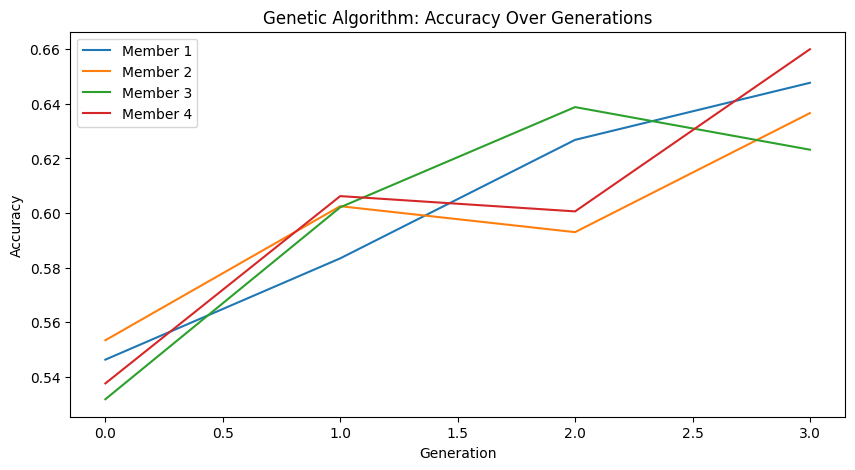

In [17]:
GA = GeneticAlgorithm(population_size=4, mutation_rate=0.05, generations=4)
GA.create_population()
GA.run_evolution(X_train, y_train, X_val, y_val, X_test, y_test)
GA.plot_accuracy()